# PyEddyTracker - Model Evaluation
## CONTENTS;
### 1. Load in data
Now, when I'm working from home, this notebook can only be used locally, however when I'm at uni I'll also be able to use this on gadi. 

For now though, we are writing this for a locally run notebook. That means that we need to find the relevant sea-level output from all datasets. 

In [1]:
from datetime import datetime

from matplotlib import pyplot as plt
import numpy as np

import xarray as xr
import glob
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37289 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37289/status,
Dashboard: /proxy/37289/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38289,Workers: 8
Dashboard: /proxy/37289/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35227,Total threads: 1
Dashboard: /proxy/36807/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:40185,


In [2]:
# set paths to model output
adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'
## SRM
eac_003 = adt_datapath + 'eac_eta_1990-2000.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac_eta_sub.nc'
## PARENT
om2_01 = adt_datapath + 'om2_eta_1990-2020.nc' 
## OBS
aviso = adt_datapath + 'cmems-sealevel-adt.nc'

## Load data
Load SSH Data (starting with AVISO)

In [3]:
aviso_raw = xr.open_dataset(aviso)
aviso_raw

<xarray.Dataset>
Dimensions:    (time: 10016, longitude: 86, latitude: 81)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-06-03
  * longitude  (longitude) float32 140.6 140.9 141.1 141.4 ... 161.4 161.6 161.9
  * latitude   (latitude) float32 -46.12 -45.88 -45.62 ... -26.62 -26.38 -26.12
Data variables:
    adt_cmems  (time, latitude, longitude) float64 ...

In [4]:
# if using access, choose second set of steps

# ssh = xr.open_dataarray(sthpac_01, chunks={'time':-1, 'xh':'auto', 'yh':'auto'})
ssh = xr.open_dataarray(om2_01, chunks={'time':-1, 'xt_ocean':'auto', 'yt_ocean':'auto'})
ssh 

<xarray.DataArray 'eta_t' (time: 10957, yt_ocean: 255, xt_ocean: 217)>
dask.array<open_dataset-eta_t, shape=(10957, 255, 217), dtype=float32, chunksize=(10957, 43, 37), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -219.5 -219.4 -219.3 ... -198.1 -198.0 -197.9
  * yt_ocean  (yt_ocean) float64 -46.22 -46.16 -46.09 ... -26.1 -26.01 -25.92
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    long_name:      surface height on T cells [Boussinesq (volume conserving)...
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

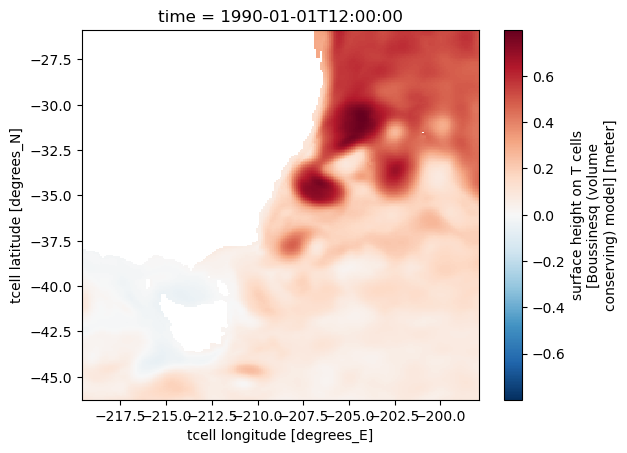

In [5]:
ssh.isel(time=0).plot()

### Regrid detrended data
Let's just do this step in a conda environment to make things easier. 

**NOTE**: Need to make this so it doesn't cut off some of the original data

In [6]:
import xesmf

In [26]:
%%time
# input grid - eac-003
# ssh_raw = ssh.rename({'yh':'lat', 'xh':'lon'})
ssh_raw = ssh.rename({'yt_ocean':'lat', 'xt_ocean':'lon'})

# output grid - sthpac-01
aviso_raw = aviso_raw.rename({'latitude':'lat', 'longitude':'lon'})
## Change time-format for MOM6 data
datetimeindex_ssh = ssh.indexes['time'].to_datetimeindex()

# regrid eac to obs
regridder_eac = xesmf.Regridder(ssh, aviso_raw, method='bilinear')

# regrid datasets;
ssh_regridded = regridder_eac(ssh_raw)

CPU times: user 706 ms, sys: 13.9 ms, total: 720 ms
Wall time: 636 ms


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('lat', 'lon') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(


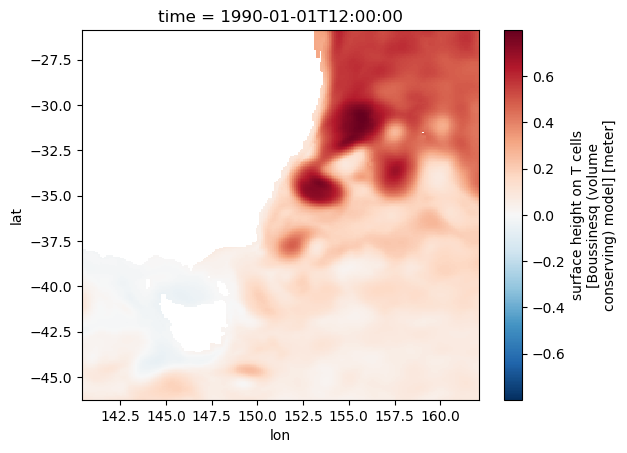

In [25]:
ssh_raw.isel(time=0).plot()

In [27]:
ssh_regridded.isel(lat=0,lon=0).plot()

2024-01-25 11:20:27,361 - distributed.worker - WARNING - Compute Failed
Key:       ('sum-a4d685e0e029fdf2a1893bc8be8dddf2', 0, 2, 3, 0, 0)
Function:  subgraph_callable-8014130c-4359-402f-9cd8-e2b2e663
args:      (<COO: shape=(81, 86, 255, 217), dtype=float64, nnz=27864, fill_value=0.0>, (slice(0, 43, None), slice(0, 37, None), slice(86, 129, None), slice(111, 148, None)), ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x14f9e8007740>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x14f9eab03d90>, encoded_fill_values={-1e+20}, decoded_fill_value=nan, dtype=dtype('float32')), dtype=dtype('float32')), key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(0, 10957, None), slice(86, 129, None), slic

RuntimeError: NetCDF: HDF error

2024-01-25 11:20:27,621 - distributed.worker - WARNING - Compute Failed
Key:       ('sum-a4d685e0e029fdf2a1893bc8be8dddf2', 0, 1, 2, 0, 0)
Function:  subgraph_callable-8014130c-4359-402f-9cd8-e2b2e663
args:      (<COO: shape=(81, 86, 255, 217), dtype=float64, nnz=27864, fill_value=0.0>, (slice(0, 43, None), slice(0, 37, None), slice(43, 86, None), slice(74, 111, None)), ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x1466689c0f40>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x14666a5b8040>, encoded_fill_values={-1e+20}, decoded_fill_value=nan, dtype=dtype('float32')), dtype=dtype('float32')), key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(0, 10957, None), slice(43, 86, None), slice(7

In [28]:
ssh_regridded.isel(time=0).plot()

2024-01-25 11:20:35,653 - distributed.worker - WARNING - Compute Failed
Key:       ('sum-a4d685e0e029fdf2a1893bc8be8dddf2', 0, 1, 3, 1, 0)
Function:  subgraph_callable-9ee40adf-642e-4c8b-b501-06033bf0
args:      (<COO: shape=(81, 86, 255, 217), dtype=float64, nnz=27864, fill_value=0.0>, (slice(43, 81, None), slice(0, 37, None), slice(43, 86, None), slice(111, 148, None)), ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x1498e7133880>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x1498e96c0c10>, encoded_fill_values={-1e+20}, decoded_fill_value=nan, dtype=dtype('float32')), dtype=dtype('float32')), key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(0, 10957, None), slice(43, 86, None), slice

RuntimeError: NetCDF: HDF error

In [11]:
# find the max longitude values for each dataset...
print(f'max longitude for model data is {ssh_raw.lon.max().values}')
print(f'max longitude for aviso data is {aviso_raw.lon.max().values}')
print(f'adjusted model longitude is {ssh_raw.lon.max().values+360}')

max longitude for model data is -197.94999999999789
max longitude for aviso data is 161.875
adjusted model longitude is 162.05000000000211


So there's a small difference/offset in the longitudes. That's fine, but we just have to slice a bit off the west side so there's not a band of NaNs getting thrown into the eddy detection

In [13]:
ssh_regridded = ssh_regridded.sel(lon=slice(aviso_raw.lon.min().values, None))
# ssh_regridded.isel(time=0).plot()

In [17]:
ssh_regridded.isel(time=10).compute()

2024-01-25 11:14:39,276 - distributed.worker - WARNING - Compute Failed
Key:       ('sum-a4d685e0e029fdf2a1893bc8be8dddf2', 0, 1, 3, 1, 0)
Function:  subgraph_callable-91650bdf-bae9-449c-99a4-117a7157
args:      (<COO: shape=(81, 86, 255, 217), dtype=float64, nnz=27864, fill_value=0.0>, (slice(43, 81, None), slice(0, 37, None), slice(43, 86, None), slice(111, 148, None)), ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x14f9e7f3f6c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x14f9eab03d90>, encoded_fill_values={-1e+20}, decoded_fill_value=nan, dtype=dtype('float32')), dtype=dtype('float32')), key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(0, 10957, None), slice(43, 86, None), slice

RuntimeError: NetCDF: HDF error

**NOTE**: Performing the above seems to remove important variable attributes such as 'units':'meters' so we also need to add those back in. We also need to rename the variable as this was lost as well!

**Re-assign attributes**

In [10]:
ssh_regridded.attrs

{'regrid_method': 'bilinear'}

In [11]:
ssh_regridded.attrs = ssh.attrs
ssh_regridded.attrs

{'units': 'm',
 'long_name': 'Sea surface height above geoid',
 'cell_methods': 'area:mean yh:mean xh:mean time: mean',
 'cell_measures': 'area: areacello',
 'time_avg_info': 'average_T1,average_T2,average_DT',
 'standard_name': 'sea_surface_height_above_geoid'}

**Re-name variable**

In [12]:
ssh_regridded.rename('zos') # this might not be correct

<xarray.DataArray 'zos' (time: 10561, lat: 81, lon: 86)>
dask.array<astype, shape=(10561, 81, 86), dtype=float32, chunksize=(10561, 61, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1990-02-01 12:00:00 ... 2018-12-31 12:00:00
  * lon      (lon) float32 140.6 140.9 141.1 141.4 ... 161.1 161.4 161.6 161.9
  * lat      (lat) float32 -46.12 -45.88 -45.62 -45.38 ... -26.62 -26.38 -26.12
Attributes:
    units:          m
    long_name:      Sea surface height above geoid
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_height_above_geoid

### Detrend data

In [13]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

In [14]:
%%time
ssh_regridded_detrended = detrend(ssh_regridded, ['time',], deg=1)
ssh_regridded_detrended

CPU times: user 104 ms, sys: 16.4 ms, total: 121 ms
Wall time: 135 ms


<xarray.DataArray (time: 10561, lat: 81, lon: 86)>
dask.array<sub, shape=(10561, 81, 86), dtype=float64, chunksize=(10561, 31, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1990-02-01 12:00:00 ... 2018-12-31 12:00:00
  * lon      (lon) float32 140.6 140.9 141.1 141.4 ... 161.1 161.4 161.6 161.9
  * lat      (lat) float32 -46.12 -45.88 -45.62 -45.38 ... -26.62 -26.38 -26.12

In [15]:
%%time
ssh_regridded_detrended.to_netcdf(adt_datapath + 'sthpac-rg-dt.nc')

CPU times: user 4.58 s, sys: 852 ms, total: 5.43 s
Wall time: 14.8 s


So - interesting to understand why the detrending is taking so long. 

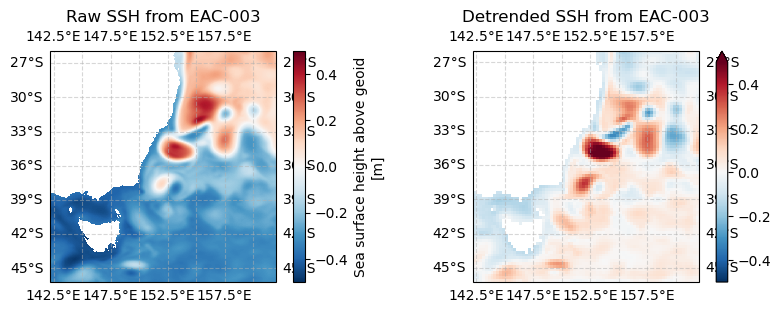

In [22]:
fig, axs = plt.subplots(1,2,figsize=(10,3), subplot_kw={'projection':ccrs.PlateCarree()})
ssh.isel(time=0).plot(ax=axs[0], vmin=-0.5, vmax=0.5, cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[0].set_title('Raw SSH from EAC-003')

eac_regridded_detrended.isel(time=0).plot(ax=axs[1], vmin=-0.5, vmax=0.5, cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[1].set_title('Detrended SSH from EAC-003')
for ax in axs.flatten():
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    ax.set_xlim(ssh.xh.min().values+360, ssh.xh.max().values+360)

So the above shows that before removing the trend, the southern part of the domain was significanlty lower in sea-level than the northern part. After removing the trend, we get an almost even distribution (which is what we'd expect).

Okay, so now we've detrended and regridded the data. Let's save this and then go through the process of `detection` and `tracking`. 

In [27]:
eac_regridded_detrended.rename('zos')

<xarray.DataArray 'zos' (time: 3803, lat: 81, lon: 86)>
dask.array<sub, shape=(3803, 81, 86), dtype=float64, chunksize=(3803, 41, 83), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2000-10-31 12:00:00
  * lon      (lon) float32 140.6 140.9 141.1 141.4 ... 161.1 161.4 161.6 161.9
  * lat      (lat) float32 -46.12 -45.88 -45.62 -45.38 ... -26.62 -26.38 -26.12

In [28]:
%%time
eac_regridded_detrended.to_netcdf(adt_datapath + 'eac-regridded-detrended.nc')

CPU times: user 17.6 s, sys: 2.59 s, total: 20.2 s
Wall time: 53.7 s


2024-01-24 14:20:21,213 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/worker.py", line 1255, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/utils_comm.py", line 455, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/utils_comm.py", line 434, in retry
    return a

In [25]:
eac_regridded_detrended.name(

<xarray.DataArray (time: 3803, lat: 81, lon: 86)>
dask.array<sub, shape=(3803, 81, 86), dtype=float64, chunksize=(3803, 41, 83), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2000-10-31 12:00:00
  * lon      (lon) float32 140.6 140.9 141.1 141.4 ... 161.1 161.4 161.6 161.9
  * lat      (lat) float32 -46.12 -45.88 -45.62 -45.38 ... -26.62 -26.38 -26.12

### Run ID algorithm (`eddy_identification`)

Okay, so the previous attempt failed because each individual map was the exact same. This stems from the fact that we set up this `RegularGridDataset` object with the full-time adt data rather than an individual snapshot. There's two options now:
1. Investigate whether some 'indexs' argument to `RegularGridDataset` could help
2. Select individual snapshots, re-save these and then try the slighly modified algorithm. 

So, I've now saved a years worth of individual dates using a bash script we've called `split-by-frame.sh`. Let's now loop through these, and save the eddy results that way...

# Track Eddies

In [5]:
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances

In [125]:
# Get files of eddy detection
ac_eddy_files = glob.glob(adt_datapath+'id-eddies_sthpac-01-filtered-dask/AC*.nc'); ac_eddy_files.sort()
cc_eddy_files = glob.glob(adt_datapath+'id-eddies_sthpac-01-filtered-dask/CC*.nc'); cc_eddy_files.sort()
print(len(ac_eddy_files), len(cc_eddy_files))


3803 3803


In [ ]:
%%time
# compute eddy tracks
ac_correspondances = Correspondances(datasets=ac_eddy_files, virtual=3)
cc_correspondances = Correspondances(datasets=cc_eddy_files, virtual=3)
# track eddies
ac_correspondances.track(); cc_correspondances.track()
ac_correspondances.prepare_merging(); cc_correspondances.prepare_merging()
# merge results
ac_eddytracks = ac_correspondances.merge(raw_data=False)
cc_eddytracks = cc_correspondances.merge(raw_data=False)
# capture virtual eddies required
ac_eddytracks.virtual[:] = ac_eddytracks.time==0
cc_eddytracks.virtual[:] = cc_eddytracks.time==0
# interpolate between virtual eddy tracks
ac_eddytracks.filled_by_interpolation(ac_eddytracks.virtual == 1)
cc_eddytracks.filled_by_interpolation(cc_eddytracks.virtual == 1)

High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 5 (nb_conflict)
High number of conflict : 5 (nb_conflict)
High number of conflict : 5 (nb_conflict)
High number of conflict : 5 (nb_co

In [122]:
trackdir_name = 'eac-003'
cc_eddytracks.write_file(adt_datapath + f'track_files/{trackdir_name}/')
ac_eddytracks.write_file(adt_datapath + f'track_files/{trackdir_name}/')

In [8]:
print(ac_eddytracks)

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 66661 observations from 14642 to 18444 (3803 days, ~18 obs/day)
    |   Speed area      : 0.18 Mkm²/day
    |   Effective area  : 0.32 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       1.34     23.13     13.82      9.16      6.58     21.12     24.85
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.02      8.26     32.19     24.09     16.24     12.83      6.34      0.02
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.01      2.35     11.73     20.41     19.71     24.17     21.39      0.23
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

In [9]:
print(cc_eddytracks)

    | 53506 observations from 14642 to 18444 (3803 days, ~14 obs/day)
    |   Speed area      : 0.14 Mkm²/day
    |   Effective area  : 0.22 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       1.64     28.18     16.76     10.82      6.87     18.81     16.93
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.07     11.24     28.46     25.63     16.23     12.12      6.22      0.03
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.03      3.63     14.39     22.44     21.77     21.95     15.71      0.07
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

Is there any way to save the results of the eddy tracking?

Okay so now I've got these eddy tracks. Let's just work through a few of the examples to get a feel for how to play around with the data.

### Display Fields
Here we use `extract_with_length` to extract eddies with tracks of a particular length. 
* `extract_with_length`: Return the observations within trajectories lasting between [b0:b1]
   * **NOTE: This is length in "days" not in distance!**

In [64]:
# set day threshold to cutoff eddies below that
upper = 100
lower = 50
cc_subset = cc_eddytracks.extract_with_length((lower, upper)) # -1 means no upper limit

In [65]:
cc_subset.nb_tracks

551

Plot Amplitude field

In [ ]:
def plot_subplots(dataset, upper, lower):
    ds_sub = dataset.extract_with_length((lower, upper))
    subplot_axes(f'N: {ds_sub.nb_tracks} | [{lower}, {upper}] days', ax)
    m = ds_sub.scatter(ax, 'age', ref=-10, s=1, transform=ccrs.PlateCarree())
    update_axes(ax, m)
    
def subplot_axes(title, ax):
    ax.set_xlim(ssh.xh.min().values+360, ssh.xh.max().values+360)
    ax.set_ylim(ssh.yh.min().values, ssh.yh.max().values)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
    
def update_axes(ax, mappable=None):
    gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.bottom_labels=False
    gs.right_labels=False
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.14, 0.05, 0.75, 0.03]), orientation='horizontal')

Text(0.5, 0.98, 'Warm Core Eddies binned by track age (%)')

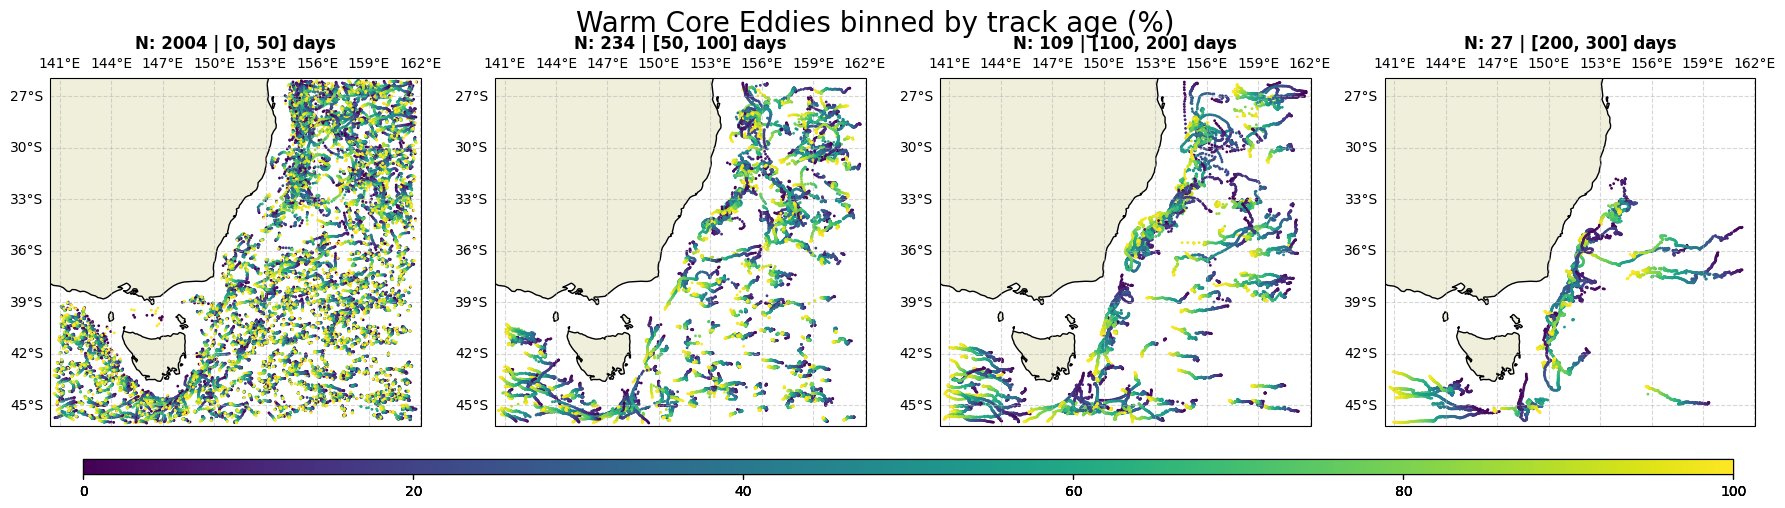

In [16]:
polarity = 'Warm'
dataset = ac_eddytracks
lower = [0, 50, 100, 200]#, 300]
upper = [50, 100, 200, 300]#, -1]
fig, axs = plt.subplots(1,4, figsize=(22,5), subplot_kw={'projection':ccrs.PlateCarree()})
for i, ax in enumerate(axs.flatten()):
    l_bnd = lower[i]
    u_bnd = upper[i]
    plot_subplots(dataset=dataset, lower=l_bnd, upper=u_bnd)
fig.suptitle(f'{polarity} Core Eddies binned by track age (%)', fontsize=20)

### Tracks which go through area
Here we use another new method called `position_filter`. This seems to a filter based on the `loess` algorithm, standing for "locally estimated scatterplot smoothing" - chatGPT refers to this as a *"weighted scatterplot smoothing algorithm. It's a non-parameteric method used for smoothing noisy data by fitting a low-degree polynomial to localised subsets of the data"*. 

**Here's the example provided in chatGPT**

In [21]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Okay that gives a pretty good idea of what we might expect this method to do. Let's go ahead and use this `position_filter`

In [25]:
cc_filt = cc_eddytracks.copy()
ac_filt = ac_eddytracks.copy()
cc_filt = cc_filt.extract_with_length((100, 300))
ac_filt = ac_filt.extract_with_length((100,300))
cc_filt.position_filter(median_half_window=1, loess_half_window=5)
ac_filt.position_filter(median_half_window=1, loess_half_window=5)

We extract eddies in the area set below, but we ask to keep `full_path`

In [37]:
x0, x1, y0, y1 = 149, 151, -43, -41
area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
cc_withinbox = cc_filt.extract_with_area(area, full_path=True)
ac_withinbox = ac_filt.extract_with_area(area, full_path=True)

#### Plot

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


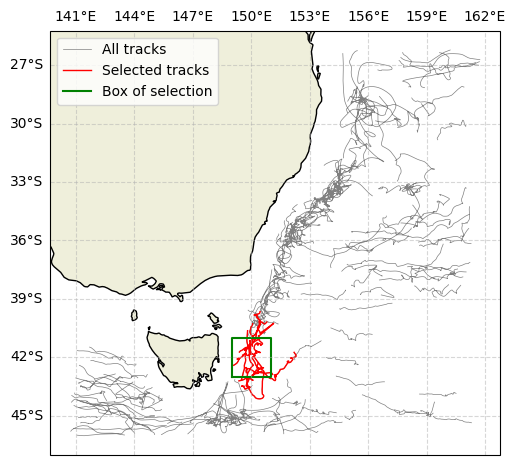

In [38]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
ac_filt.plot(ax, color='grey', lw=0.5, ref=-10, label="All tracks", transform=ccrs.PlateCarree())
ac_withinbox.plot(
    ax, color='r', lw=1, ref=-10, label='Selected tracks', transform=ccrs.PlateCarree())
ax.add_feature(feature.LAND)
ax.coastlines()
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.bottom_labels=False
gs.right_labels=False

ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color='g',
    lw=1.5,
    label='Box of selection'
)
ax.legend()

This again is a pretty cool feature and will come in handy and look more interesting when combined with the 'extract_with_length' method as well as longer timeseries.

### One Track
Using the `extract_longer_eddies` method, we determine a threshold whereby 

In [34]:
eddy = ac_eddytracks.extract_with_length((100,-1))
eddy

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


| 23112 observations from 14642 to 18444 (3803 days, ~6 obs/day)
    |   Speed area      : 0.07 Mkm²/day
    |   Effective area  : 0.15 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.27      8.23     10.42      7.67      6.33     25.46     41.63
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      4.33     33.51     21.49     17.34     14.72      8.58      0.02
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.83      6.07     12.70     16.28     29.23     34.53      0.36
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     59.56       nan       nan       nan
        Mean effective radius (km):        nan     90.51       nan       nan       nan
        Mean amplitude (cm)       :        nan     12.39       nan       nan       nan
    | 141 tracks (163.91 obs/tracks, shorter 100 obs, longer 551 obs)
    |   456 filled observations (3.23 obs/tracks, 1.97 % of total)
    |   Intepolated speed area      : 0.00 Mkm²/day
    |   Intepolated effective area  : 0.00 Mkm²/day
    |   Distance by day             : Mean 4.58 , Median 2.94 km/day
    |   Distance by track           : Mean 742.11 , Median 667.32 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :       0.00      0.00     71.63     22.70      3.55      2.13      0.00
    |   Percent of eddies         :       0.00      0.00     56.72     30.12      6.47      6.69      0.00

In [39]:
# filter
eddy.position_filter(median_half_window=1, loess_half_window=5)

In [40]:
kw_ax = dict(rect=(0.05, 0.05, 0.9, 0.9), projection=ccrs.PlateCarree())
def start_axes(title):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes(**kw_ax)
    ax.set_title(title, weight='bold')
    ax.add_feature(feature.LAND)
    ax.coastlines()
    return ax
def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
    

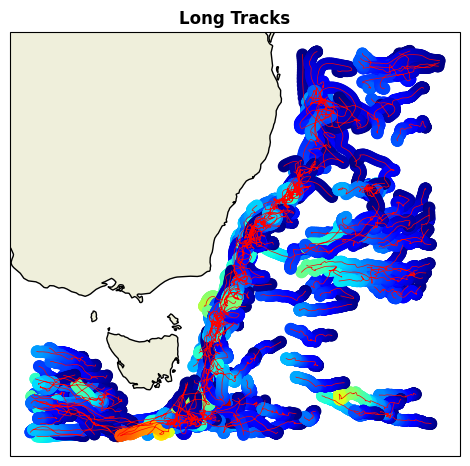

In [41]:
# Plot
ax = start_axes('Long Tracks')
eddy.plot(ax, color='r', lw=0.5)
eddy.scatter(ax, 'n', cmap='jet', s=60)
update_axes(ax)

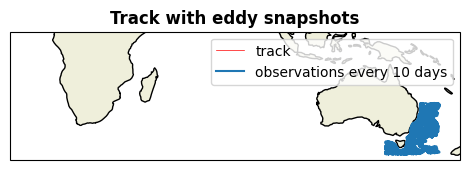

In [42]:
# Plot track with shape snapshots
ax = start_axes('Track with eddy snapshots')
eddy.plot(ax, color='r', lw=0.5, label='track')
eddy.index(range(0, len(eddy), 30)).display(
    ax, intern_only=True, label="observations every 10 days")
ax.legend()

That index method is a good trick - select only particular timesteps of an eddies track

### Display Tracks

In [43]:
# keep eddies longer than 20 weeks
ac_long = ac_eddytracks.extract_with_length((7*10, -1))
cc_long = cc_eddytracks.extract_with_length((7*10, -1))
print(ac_long)
print(cc_long)

    | 32201 observations from 14642 to 18444 (3803 days, ~8 obs/day)
    |   Speed area      : 0.10 Mkm²/day
    |   Effective area  : 0.20 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.32     10.82     11.01      7.56      6.47     25.04     38.79
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      5.10     32.95     21.95     16.86     14.50      8.62      0.02
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.74      6.25     14.43     17.26     28.69     32.30      0.33
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00   

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


Position filter for nicer display

In [44]:
ac_long.position_filter(median_half_window=1, loess_half_window=5)
cc_long.position_filter(median_half_window=1, loess_half_window=5)

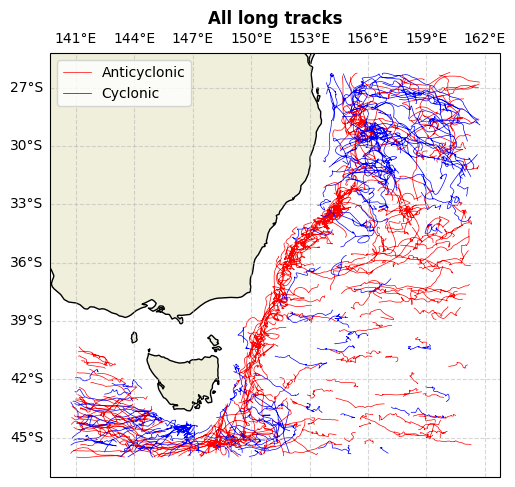

In [46]:
# Plot
ax = start_axes('All long tracks')
ac_long.plot(ax, ref=-10, label="Anticyclonic", color='r', lw=0.5)
cc_long.plot(ax, ref=-10, label="Cyclonic", color='b', lw=0.5)
ax.legend()
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.bottom_labels=False
gs.right_labels=False

## Tracking Diagnostics
### Geographical Statistics

In [47]:
# Merge ac and cc
eddies_merged = ac_eddytracks.merge(cc_eddytracks)
step = 0.1

Mean of amplitude in each box

In [51]:
coord_bounds = {'W':ssh.xh.min().values, 'E':ssh.xh.max().values,
                'S':ssh.yh.min().values, 'N':ssh.yh.max().values}

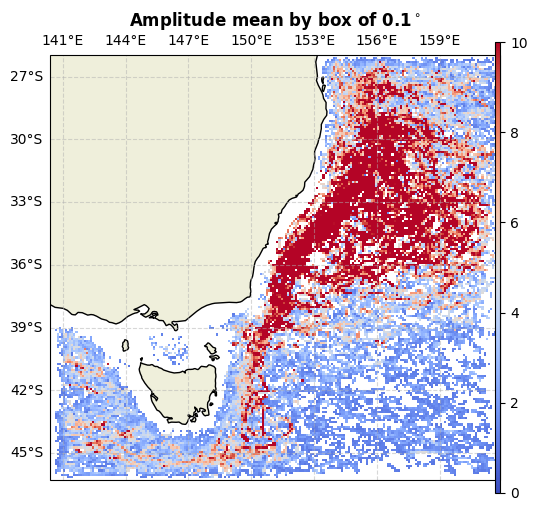

In [55]:
ax = start_axes("Amplitude mean by box of %s$^\circ$" % step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step), 
                            (coord_bounds['S'], coord_bounds['N'], step)), 
                            varname='amplitude')
m = g.display(ax, name='amplitude', vmin=0, vmax=10, factor=100)
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.bottom_labels=False
gs.right_labels=False
update_axes(ax, m)

This is a nice thing to summarise the eddy data and would also be interesting to compare with other outputs. 

Is this amount of amplitude far to high though? I'm guessing it's showin 10cm in those areas?

Mean of speed radius in each box

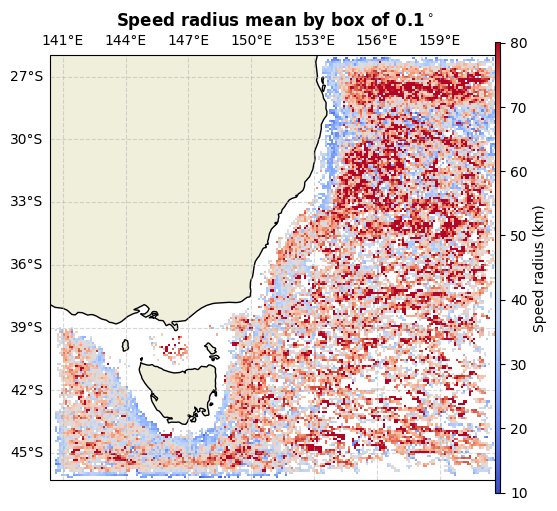

In [57]:
ax = start_axes("Speed radius mean by box of %s$^\circ$" % step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step), 
                            (coord_bounds['S'], coord_bounds['N'], step)), 
                            "radius_s")
m = g.display(ax, name='radius_s', vmin=10, vmax=80, factor=0.001)
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.bottom_labels=False
gs.right_labels=False
cb = plt.colorbar(m, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
cb.set_label("Speed radius (km)")
                            

Percent of virtual on the whole obs in each box

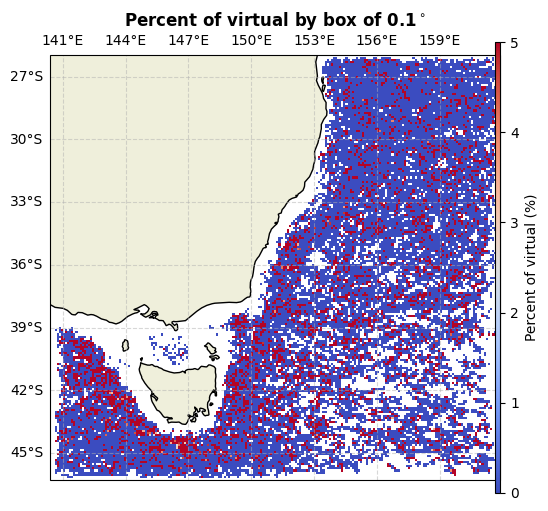

In [63]:
ax = start_axes("Percent of virtual by box of %s$^\circ$" %step)
g = eddies_merged.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                             (coord_bounds['S'], coord_bounds['N'], step)),
                            "virtual")
g.vars['virtual'] *= 100
m = g.display(ax, name='virtual', vmin=0, vmax=5)
gs = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.bottom_labels=False
gs.right_labels=False
cb = plt.colorbar(m, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
cb.set_label("Percent of virtual (%)")

## Birth & Death
Following figures are based on https://doi.org/10.1016/j.pocean.2011.01.002

In [90]:
t0, t1 = ac_eddytracks.period
step = 0.125
bins = ((coord_bounds['W'], coord_bounds['E'], step), (coord_bounds['S'], coord_bounds['N'], step))
kwargs = dict(cmap='terrain_r', factor=100 / (t1 - t0), name='count', vmin=0, vmax=0.1)

#### Cyclonic

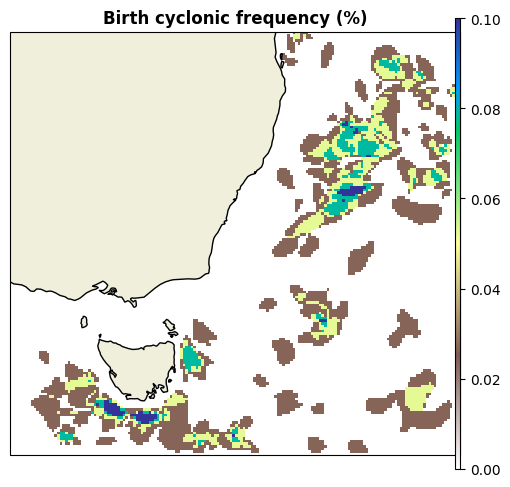

In [91]:
ax = start_axes("Birth cyclonic frequency (%)")
g_c_first = cc_long.first_obs().grid_count(bins, intern=True)
m = g_c_first.display(ax, **kwargs)
update_axes(ax, m)

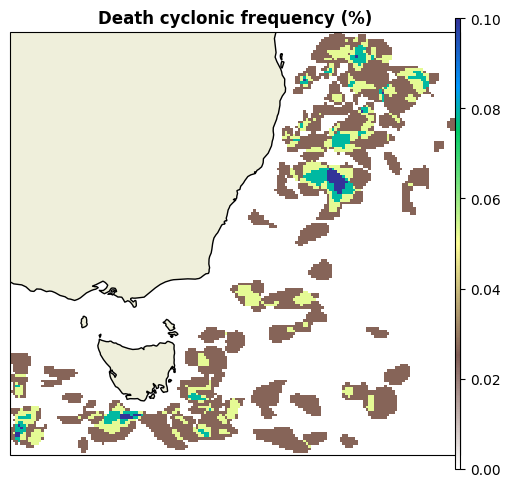

In [92]:
ax = start_axes("Death cyclonic frequency (%)")
g_c_last = cc_long.last_obs().grid_count(bins, intern=True)
m = g_c_last.display(ax, **kwargs)
update_axes(ax, m)

#### Anticyclonic

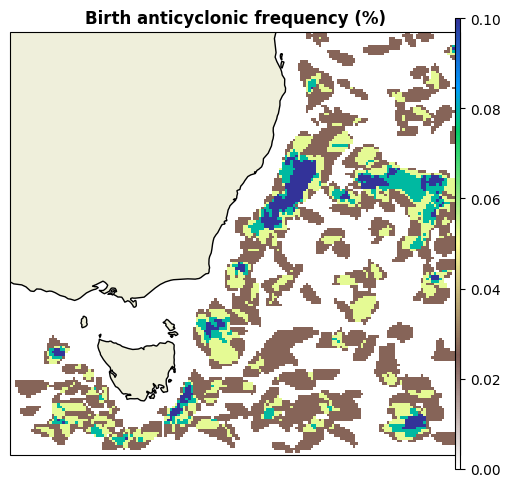

In [93]:
ax = start_axes("Birth anticyclonic frequency (%)")
g_a_first = ac_long.first_obs().grid_count(bins, intern=True)
m = g_a_first.display(ax, **kwargs)
update_axes(ax, m)

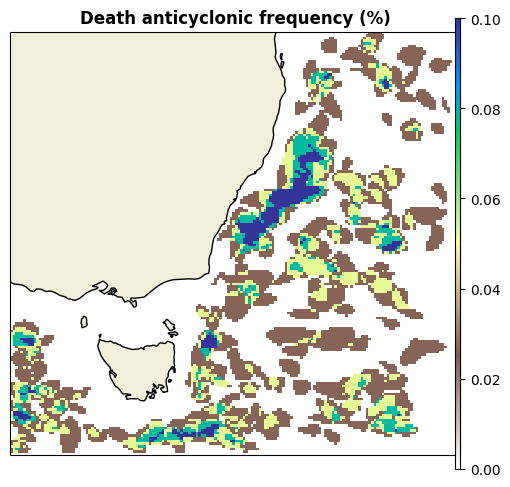

In [94]:
ax = start_axes("Death anticyclonic frequency (%)")
g_a_last = ac_long.last_obs().grid_count(bins, intern=True)
m = g_a_last.display(ax, **kwargs)
update_axes(ax, m)

## Lifetime Histograms

In [96]:
nb_year = (t1 - t0 + 1) / 365.25
nb_year

10.412046543463381

Setup Axes

In [100]:
from numpy import arange, ones


/jobfs/106970237.gadi-pbs/ipykernel_4121698/380527277.py:32: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio_cum.plot(x, cum_c / cum_a)
/jobfs/106970237.gadi-pbs/ipykernel_4121698/380527277.py:33: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio.plot(x, nb_c / nb_a)


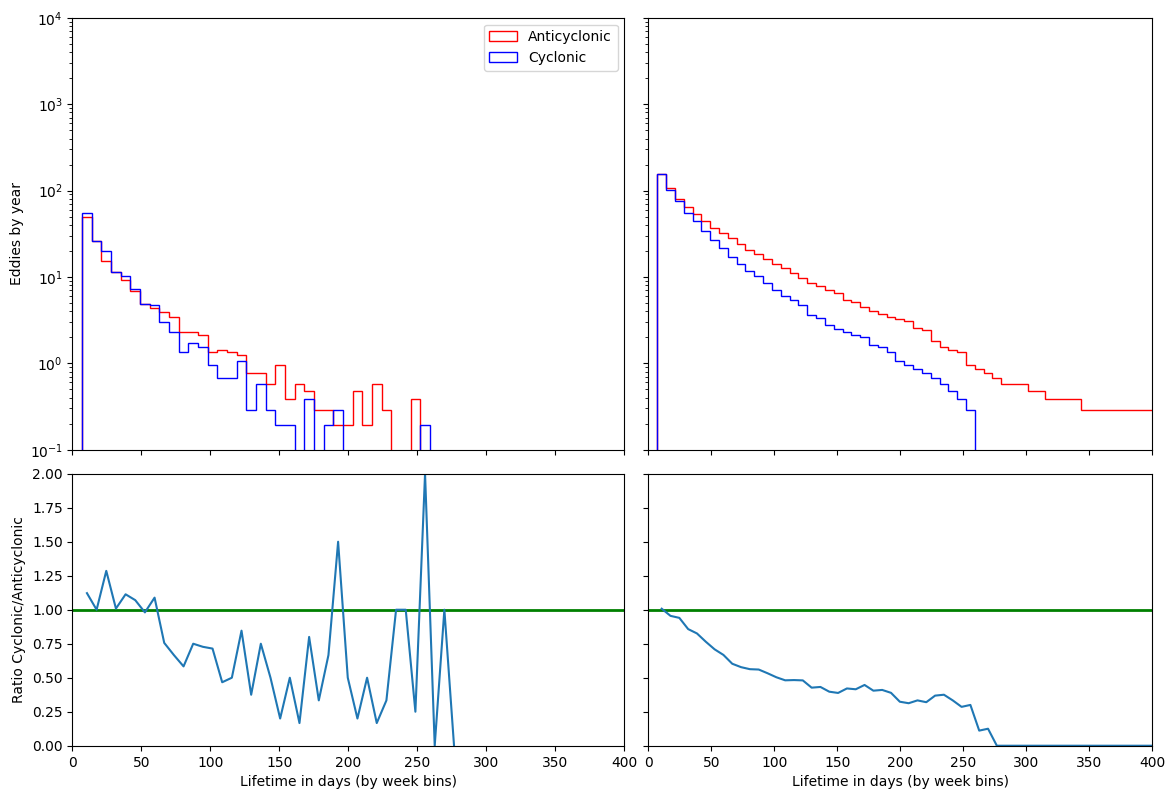

In [101]:
figure = plt.figure(figsize=(12,8))
ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")
ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum, ax_ratio_cum, ax_ratio):
    ax_.set_xlim(0,400)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e4), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0,2)
        ax_.axhline(1, color='g', lw=2)
    ax.grid()
ax_cum.xaxis.set_ticklabels([]), ax_cum.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([]), ax_ratio_cum.yaxis.set_ticklabels([])

# plot data
bin_hist = arange(7, 2000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb = ac_eddytracks.nb_obs_by_track, cc_eddytracks.nb_obs_by_track
a_nb, c_nb = a_nb[a_nb != 0], c_nb[c_nb != 0]
w_a, w_c = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year
kwargs_a = dict(histtype="step", bins=bin_hist, x=a_nb, color="r", weights=w_a)
kwargs_c = dict(histtype="step", bins=bin_hist, x=c_nb, color="b", weights=w_c)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_a)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_c)
nb_a, _, _ = ax.hist(label="Anticyclonic", **kwargs_a)
nb_c, _, _ = ax.hist(label="Cyclonic", **kwargs_c)
ax_ratio_cum.plot(x, cum_c / cum_a)
ax_ratio.plot(x, nb_c / nb_a)
ax.legend()

The above is a good summary or overview of the distributions of ac/cc eddies overall and it could be a nice way to see the differences between the different datasets. 

## Parameter Histogram

In [102]:
kwargs_a = dict(label = "Anticyclonic", color='r', histtype='step', density=True)
kwargs_c = dict(label = "Cyclonic", color='b', histtype='step', density=True)

In [108]:
ac_eddytracks.speed_radius

array([34050., 33200., 33100., ..., 44650., 44350., 40050.], dtype=float32)

/jobfs/106970237.gadi-pbs/ipykernel_4121698/3202137718.py:30: RuntimeWarning: divide by zero encountered in true_divide
  ax_ratio.plot((bins[1:] + bins[:-1]) / 2, nb_c / nb_a)
/jobfs/106970237.gadi-pbs/ipykernel_4121698/3202137718.py:30: RuntimeWarning: invalid value encountered in true_divide
  ax_ratio.plot((bins[1:] + bins[:-1]) / 2, nb_c / nb_a)


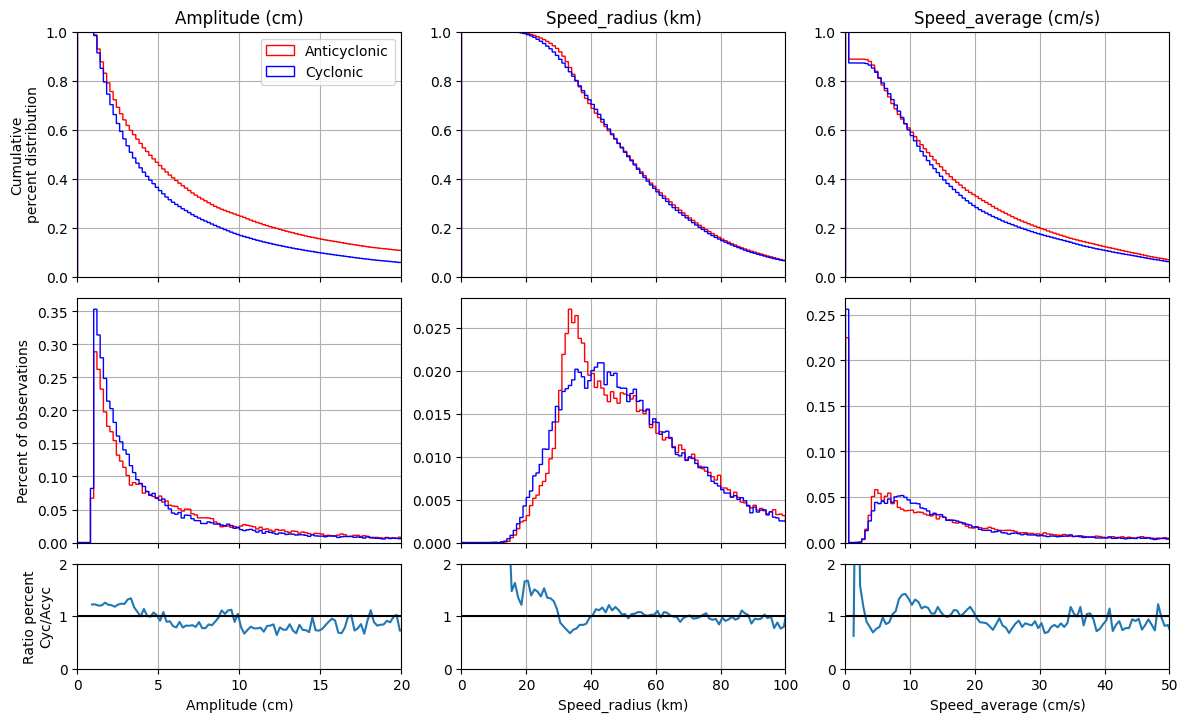

In [111]:
fig = plt.figure(figsize=(12,7))

for x0, name, title, xmax, factor, bins in zip(
    (0.4, 0.72, 0.08), 
    ("speed_radius", "speed_average", "amplitude"),
    ("Speed_radius (km)", "Speed_average (cm/s)", "Amplitude (cm)"),
    (100, 50, 20), 
    (0.001, 100, 100), 
    (arange(0, 2000, 1), arange(0, 1000, 0.5), arange(0.0005, 1000, 0.2)),
):
    ax_hist = fig.add_axes((x0, 0.24, 0.27, 0.35))
    nb_a, _, _ = ax_hist.hist(ac_eddytracks[name] * factor, bins=bins, **kwargs_a)
    nb_c, _, _ = ax_hist.hist(cc_eddytracks[name] * factor, bins=bins, **kwargs_c)
    ax_hist.set_xticklabels([])
    ax_hist.set_xlim(0, xmax)
    ax_hist.grid()
    
    ax_cum = fig.add_axes((x0, 0.62, 0.27, 0.35))
    ax_cum.hist(ac_eddytracks[name] * factor, bins=bins, cumulative=-1, **kwargs_a)
    ax_cum.hist(cc_eddytracks[name] * factor, bins=bins, cumulative=-1, **kwargs_c)
    ax_cum.set_xticklabels([])
    ax_cum.set_title(title)
    ax_cum.set_xlim(0, xmax)
    ax_cum.set_ylim(0, 1)
    ax_cum.grid()

    ax_ratio = fig.add_axes((x0, 0.06, 0.27, 0.15))
    ax_ratio.set_xlim(0, xmax)
    ax_ratio.set_ylim(0, 2)
    ax_ratio.plot((bins[1:] + bins[:-1]) / 2, nb_c / nb_a)
    ax_ratio.axhline(1, color='k')
    ax_ratio.grid()
    ax_ratio.set_xlabel(title)

ax_cum.set_ylabel("Cumulative\npercent distribution")
ax_hist.set_ylabel("Percent of observations")
ax_ratio.set_ylabel("Ratio percent\nCyc/Acyc")
ax_cum.legend()

What information do I get out of these plots? 
* Considering Amplitude: With increasing amplitude, the "*cumulative percent distribution*" and the "*percent of observations*" decreases inverse-exponentially. This translates to lesser portion of eddies having a high amplitude than those having a low amplitude.
  * The peak in amplitude appears around 2cm, whilst the ratio with respect to amplitude is quite even across all amplitudes.
* I still don't fully comprehend the `speed_radius` however I believe it has something to do with the maximum tangential velocity of the eddy.

I think if we use something like the above plots but compare them between the model runs, than that could be a reasonable metric to compare/evaluate the performance of the models. 

Also it might be cool to identify the largest eddy by each measurement (e.g., longest, highest Amplitude, largest speed-radius, highest speed etc.) and visualise these eddies. We could then make some case studies that investigate the lifecycle of these - are there eddies of similar magnitude in the other model output? 